Based on the blog post https://www.earlevel.com/main/2017/05/26/guitar-amp-simulation/

In [23]:
import numpy as np
import librosa
from librosa.display import specshow
from matplotlib import pyplot as plt
from IPython.display import Audio

In [63]:
fs = 44100

x, _ = librosa.load('data/chords.wav', sr=44100)

In [25]:
Audio(x, rate=fs)

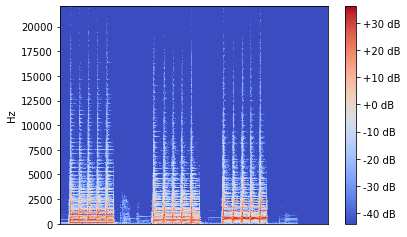

In [26]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(x))),
                        y_axis='linear',
                        sr=fs)
plt.colorbar(format='%+2.0f dB')

In [45]:
gain = 5.0

y = gain * x

def tube(x, sat=1.0, clipping='hard'):
    x[x > sat] = sat
    x[x < -sat] = -sat
    if clipping == 'soft':
        idx_not_clipped = (x > -sat) & (x < sat)
        x[idx_not_clipped] *= 2 - np.abs(x[idx_not_clipped])
    return x
        
y_hard_clipped = tube(y)
y_soft_clipped = tube(y, clipping='soft')

def amp(x, gain=1.0, clipping='soft'):
    return tube(gain * x, clipping=clipping)

y_hard = amp(x, gain=gain, clipping='hard')
y_soft = amp(x, gain=gain, clipping='soft')

In [46]:
Audio(y_hard, rate=fs)

In [47]:
Audio(y_soft, rate=fs)

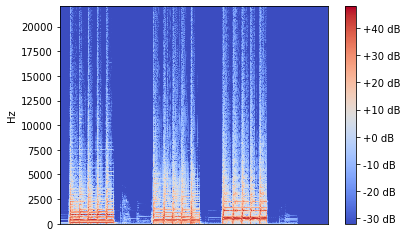

In [48]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_hard))),
                        y_axis='linear',
                        sr=fs)
plt.colorbar(format='%+2.0f dB')

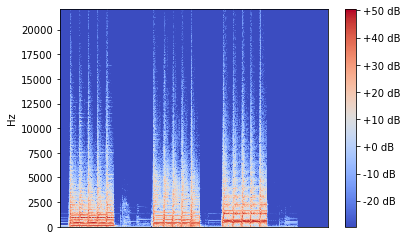

In [49]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_soft))),
                        y_axis='linear',
                        sr=fs)
plt.colorbar(format='%+2.0f dB')

In [50]:
import soundfile

def towav(fname, x, fs):
    x_norm = 0.95*x/max(abs(x))
    soundfile.write(fname, x_norm, fs)

towav('data/hard_clipping.wav', y_hard, fs)
towav('data/soft_clipping.wav', y_soft, fs)

## Oversampling before clipping

In [51]:
import resampy

oversampling_factor = 8.0

x_oversampled = resampy.resample(x, fs, oversampling_factor * fs)

y_soft_os = amp(x_oversampled, gain, clipping='soft')
y_hard_os = amp(x_oversampled, gain, clipping='hard')

y_soft_ds = resampy.resample(y_soft_os, oversampling_factor * fs, fs)
y_hard_ds = resampy.resample(y_hard_os, oversampling_factor * fs, fs)

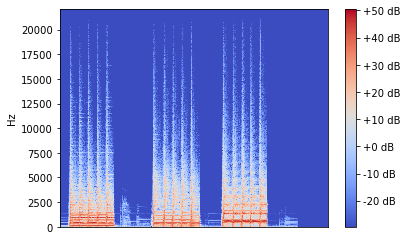

In [52]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_soft_ds))),
                        y_axis='linear',
                        sr=fs)
plt.colorbar(format='%+2.0f dB')

In [53]:
Audio(y_soft_ds, rate=fs)

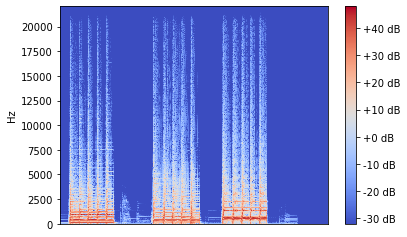

In [54]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_hard_ds))),
                        y_axis='linear',
                        sr=fs)
plt.colorbar(format='%+2.0f dB')

In [55]:
Audio(y_hard_ds, rate=fs)

In [56]:
towav('data/soft_clipping_oversampled.wav', y_soft_ds, fs)
towav('data/hard_clipping_oversampled.wav', y_hard_ds, fs)

## Adding tone control

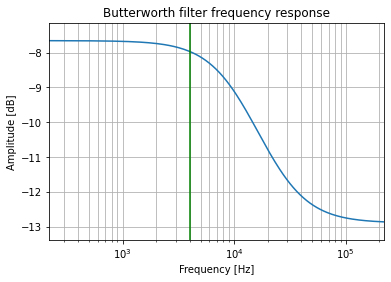

In [57]:
from scipy.signal import butter, sosfilt, freqs

fc = 4000

b, a = butter(1, fc, btype='lowpass', fs=fs)
sos = butter(1, fc, btype='lowpass', fs=fs, output='sos')

w, h = freqs(b, a)
plt.semilogx(0.5*fs*w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(fc, color='green') # cutoff frequency
plt.show()

In [58]:
y_filtered = sosfilt(sos, y_soft_ds)
Audio(y_filtered, rate=fs)

In [59]:
towav('with_tone.wav', y_filtered, fs)

## Adding a cabinet simulator

In [64]:
from scipy.signal import fftconvolve

ir, _ = librosa.load('data/ir.wav', sr=fs)

y_cabsim = fftconvolve(y_filtered, ir, mode='same')

In [65]:
Audio(y_cabsim, rate=fs)

In [66]:
towav('data/with_cabsim.wav', y_cabsim, fs)